In [1]:
import os, mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from fooof import FOOOF
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fm, get_band_peak_fg
from fooof.plts.periodic import plot_peak_fits, plot_peak_params
from fooof.plts.aperiodic import plot_aperiodic_params, plot_aperiodic_fits
from fooof.plts.spectra import plot_spectra_shading, plot_spectrum
from fooof.plts.utils import check_ax, check_plot_kwargs

from signal_processing.spectral_analysis import calculate_psd
import basic.arrange_data as arrange

In [2]:
clean_folder = r"Data/Clean/"
results_foldername = r"Results/"
exp_folder = r"test"
exp_condition = r"EC_test"
freq_range = [1,30]
# note: probably have to re-preprocess the data with higher high-cutoff frequency than the used freq in here
# to avoid that part of the higher frequency spectra gets cut off which affects model fitting

brain_regions = {'Frontal':['Fp1','Fp2','AF3','AF4','F3','F4','F7','F8','Fz',
                            'FC5','FC6','FC1','FC2'],
                 'Parietal':['C3','C4','Cz','CP5','CP6','CP1','CP2','P3','P4',
                            'Pz','PO3','PO4']}
# before fooof estimation, for a region, average channels' power together and apply fooof on that

Files in Data/Clean/test read in: 1


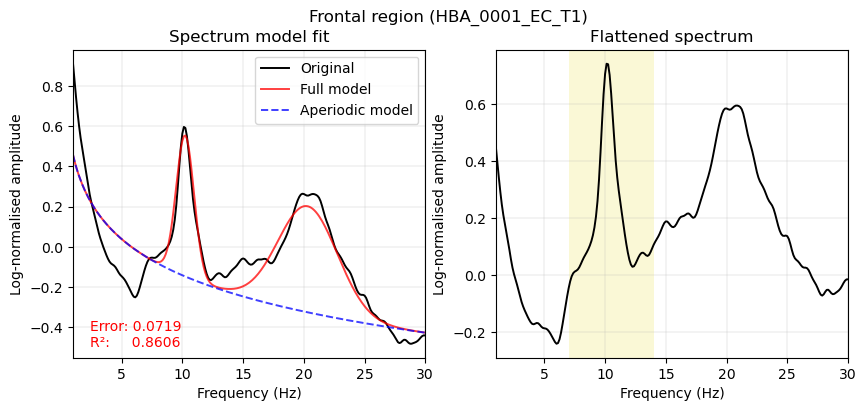

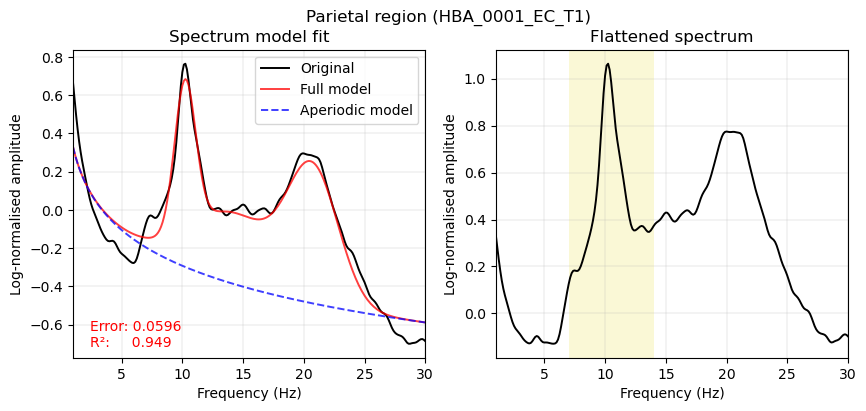

,Exponent,Offset,Peaks_CF,Peaks_PW,Peaks_BW,R_2,Error
HBA_0001_EC_T1,0.598598,0.456958,"[10.22929806492512, 20.307898714509804]","[0.7016270369729707, 0.5275962214780945]","[1.4729982247094282, 4.904981144863099]",0.860634,0.071893


,Exponent,Offset,Peaks_CF,Peaks_PW,Peaks_BW,R_2,Error
HBA_0001_EC_T1,0.621686,0.329337,"[10.222305671834834, 14.123485959157602, 20.77...","[0.9833461796665774, 0.37305422113813985, 0.73...","[1.7317940434597168, 7.1293205899730365, 4.187...",0.948951,0.059591


In [38]:
dir_inprogress = os.path.join(clean_folder,exp_folder)
file_dirs, subject_names = arrange.read_files(dir_inprogress,"_clean-epo.fif")
#df_fooof = pd.DataFrame(index=subject_names,columns=['Exponent','Offset','Peaks_CF','Peaks_PW','Peaks_BW','R_2','Error'])

# Define frequency bands of interest
bands = Bands({'alpha' : [7, 14]})

# Set the amplitude scale either to be linear or logarithmic
flat_spectr_scale = 'log'

#t_settings = {'fontsize' : 12, 'fontweight' : 'bold'}
shade_cols = ['#e8dc35', '#46b870', '#1882d9', '#a218d9', '#e60026']
labels = ['Group-1', 'Group-2']

# shape: [region][subject]
deltas = [[None]*len(file_dirs)]*len(brain_regions.keys())
thetas = [[None]*len(file_dirs)]*len(brain_regions.keys())
alphas = [[None]*len(file_dirs)]*len(brain_regions.keys())
betas = [[None]*len(file_dirs)]*len(brain_regions.keys())
aps = [[None]*len(file_dirs)]*len(brain_regions.keys())

# Pre-create results folders for spectral analysis data
arrange.create_results_folders(exp_folder='',results_foldername=results_foldername)

# Go through all the files (subjects) in the folder
for i in range(len(file_dirs)):
    # Read the clean data from the disk
    epochs = mne.read_epochs(fname='{}/{}_clean-epo.fif'.format(dir_inprogress,subject_names[i]),verbose=False)

    # Calculate Welch's power spectrum density (FFT) -> (epochs, channels, freq bins) shape
    [psds,freqs] = calculate_psd(epochs,subject_names[i],fminmax=freq_range,window='hamming',
                                 window_duration=2,window_overlap=0.5,zero_padding=3,verbose=False,plot=False)
    
    # Average all epochs and channels together -> (freq bins,) shape
    psds_allch = psds.mean(axis=(0,1))

    # Average all epochs together for each channel and also for each region
    psds = psds.mean(axis=(0))
    df_psds_ch = arrange.array_to_df(subject_names[i],epochs,psds).reset_index().drop(columns='Subject')
    df_psds_regions = arrange.df_channels_to_regions(df_psds_ch,brain_regions).reset_index().drop(columns='Subject')

    # Loop through all regions of interest
    for region in df_psds_regions.columns:
        if i == 0:
            globals()["df_fooof_"+region] = pd.DataFrame(index=subject_names,columns=['Exponent','Offset','Peaks_CF','Peaks_PW','Peaks_BW','R_2','Error'])
        max_n_peaks = float("inf")
        psds_temp = df_psds_regions[region].to_numpy()

        # Fit the spectrum with FOOOF        
        fm = FOOOF(peak_width_limits=[1,12],max_n_peaks=max_n_peaks,min_peak_height=0.225,
                peak_threshold=2.0,aperiodic_mode='fixed',verbose=True)
        fm.fit(freqs,psds_temp,freq_range)
            
        # Log-linear conversion based on the chosen amplitude scale
        if flat_spectr_scale == 'linear':
            flatten_spectrum = 10 ** fm._spectrum_flat
            flat_spectr_ylabel = 'Amplitude (uV\u00b2/Hz)'
        elif flat_spectr_scale == 'log':
            flatten_spectrum = fm._spectrum_flat
            flat_spectr_ylabel = 'Log-normalised amplitude'

        # Set plot styles
        data_kwargs = {'color' : 'black', 'linewidth' : 1.4,
                       'label' : 'Original'}
        model_kwargs = {'color' : 'red', 'linewidth' : 1.4, 'alpha' : 0.75,
                        'label' : 'Full model'}
        aperiodic_kwargs = {'color' : 'blue', 'linewidth' : 1.4, 'alpha' : 0.75,
                            'linestyle' : 'dashed', 'label' : 'Aperiodic model'}
        flat_kwargs = {'color' : 'black', 'linewidth' : 1.4}
        errorbox_kwargs = {'color' : 'red', 'xycoords' : 'figure fraction'}

        # Plot power spectrum model, aperiodic fit + flattened spectrum (minus aperiodic fit)
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
        plot_spectrum(fm.freqs, fm.power_spectrum,
                      ax=axs[0], plot_style=None, **data_kwargs)
        plot_spectrum(fm.freqs, fm.fooofed_spectrum_,
                      ax=axs[0], plot_style=None, **model_kwargs)
        plot_spectrum(fm.freqs, fm._ap_fit,
                      ax=axs[0], plot_style=None, **aperiodic_kwargs)
        axs[0].set_xlim(freq_range)
        axs[0].grid(linewidth=0.2)
        axs[0].set_xlabel('Frequency (Hz)')
        axs[0].set_ylabel('Log-normalised amplitude')
        axs[0].set_title('Spectrum model fit')
        axs[0].legend()
        axs[0].annotate('Error: ' + str(np.round(fm.get_params('error'), 4)) +
                        '\nR\u00b2:     ' + str(np.round(fm.get_params('r_squared'), 4)),
                        (0.09, 0.16), **errorbox_kwargs)
        
        plot_spectra_shading(fm.freqs, [flatten_spectrum], shades=bands.definitions,
                             shade_colors=shade_cols, ax=axs[1], plot_style=None, **flat_kwargs)
        axs[1].set_xlim(freq_range)
        axs[1].grid(linewidth=0.2)
        axs[1].set_xlabel('Frequency (Hz)')
        axs[1].set_ylabel(flat_spectr_ylabel)
        axs[1].set_title('Flattened spectrum')
        
        plt.suptitle('{} region ({})'.format(region,subject_names[i]))
        plt.show()

        # Add model parameters to dataframe
        
        ### UPDATE later according to linear or log scale for peaks!!!
        
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'Exponent'] = fm.get_params('aperiodic_params','exponent')
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'Offset'] = fm.get_params('aperiodic_params','offset')
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'Peaks_CF'] = fm.get_params('peak_params', 'CF')
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'Peaks_PW'] = fm.get_params('peak_params', 'PW')
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'Peaks_BW'] = fm.get_params('peak_params', 'BW')
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'R_2'] = fm.get_params('r_squared')
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'Error'] = fm.get_params('error')

# Export FOOOF data for all regions
for region in df_psds_regions.columns:
    globals()["df_fooof_"+region].to_excel(r"{}/FOOOF/{}/{}_{}_fooof.xlsx".format(results_foldername,exp_folder,exp_condition,region))
    display(globals()["df_fooof_"+region])

10.222305671834834 0.9833461796665774 1.7317940434597168


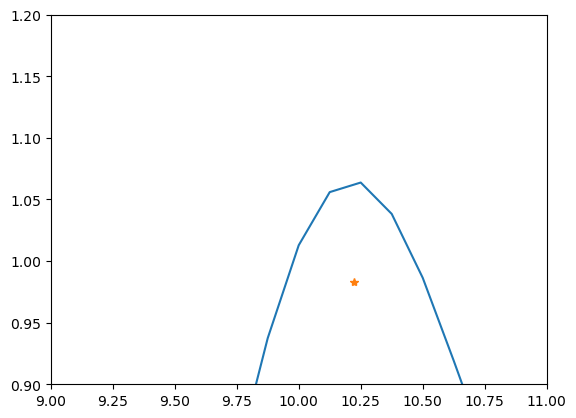

In [37]:
import fooof

# plt.figure()
# fm.plot(plot_peaks='shade', peak_kwargs={'color' : 'green'})
# plt.show()

#fooof.analysis.periodic.get_band_peak(, bands.alpha, select_highest=True, threshold=None, thresh_param='PW')
[cf,pw,bw] = fooof.analysis.get_band_peak_fm(fm, bands.alpha, select_highest=True) # i think this peak is the model fit peak!!!!

#bw_idx = np.where(np.logical_and(flatten_spectrum >= bands.alpha[0], flatten_spectrum <= bands.alpha[1]))

#pw = np.max(flatten_spectrum[bw_idx])

print(cf,pw,bw)
#print(freqs)
plt.figure()
plt.plot(freqs,flatten_spectrum)
plt.plot(cf,pw,'*')
plt.ylim([0.9,1.2])
plt.xlim([9,11])
plt.show()

In [ ]:
# df_exponents = pd.DataFrame({'Frontal': aps[0,:,1],
#                        'Parietal': aps[1,:,1]})

# #from statannotations.Annotator import Annotator

# fig = plt.figure(dpi=100)
# ax = sns.swarmplot(data=df_exponents)
# plt.ylabel('Exponent')
# # annotator = Annotator(ax,pairs=[('Baseline','6 weeks'),('6 weeks','10 weeks'),('Baseline','10 weeks')],
# #                       data=df_aps,plot="swarmplot")\
# #                       .configure(test='t-test_paired')\
# #                       .apply_test().annotate()

# fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15, 6))
# # Plot the aperiodic parameters for all groups
# plot_aperiodic_params([aps[0],aps[1]],labels=['Frontal','Parietal'],ax=ax[0])
# # Plot the aperiodic fits for all groups
# plot_aperiodic_fits([aps[0],aps[1]],freq_range,control_offset=True,log_freqs=False,labels=['Frontal','Parietal'],ax=ax[1])

# # Compare the peak parameters of theta,alpha,beta peaks between groups
# fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(20, 6))
# plot_peak_params([thetas_00,thetas_06,thetas_07], freq_range=bands.theta, labels=labels,ax=ax[0])
# ax[0].set_title('Theta')
# plot_peak_params([alphas_00,alphas_06,alphas_07], freq_range=bands.alpha, labels=labels,ax=ax[1])
# ax[1].set_title('Alpha')
# plot_peak_params([betas_00,betas_06,betas_07], freq_range=bands.beta, labels=labels,ax=ax[2])
# ax[2].set_title('Beta')

# # Compare the peak fits of theta,alpha,beta peaks between groups
# fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(20, 6))
# plot_peak_fits([thetas_00,thetas_06,thetas_07],labels=labels,ax=ax[0])
# ax[0].set_title('Theta')
# plot_peak_fits([alphas_00,alphas_06,alphas_07],labels=labels,ax=ax[1])
# ax[1].set_title('Alpha')
# plot_peak_fits([betas_00,betas_06,betas_07],labels=labels,ax=ax[2])
# ax[2].set_title('Beta')

**An example of including FOOOF in Methods section**

The FOOOF algorithm (version X.X.X) was used to parameterize neural power spectra. Settings for the algorithm were set as: peak width limits : XX; max number of peaks : XX; minimum peak height : XX; peak threshold : XX; and aperiodic mode : XX. Power spectra were parameterized across the frequency range XX to XX Hz.

*Source: https://fooof-tools.github.io/fooof/reference.html*

In [ ]:
fm.print_settings(description=True)